In [10]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
from scipy.optimize import curve_fit
import pickle

importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)

<module 'Modules.figures' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\figures.py'>

<Figure size 640x480 with 0 Axes>

In [11]:
# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False

np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [12]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9
h   = 6.626e-34
e0  = 1.602e-19
Φ_0 = h / (2 * e0)

# Theoretical model Jx Jy Jz

# Fitting functions

In [17]:
def lin_fit(x,m,n):
    return(m*x+n)

def damped_oscillation(t, A, tau, f, phase, off):
    return A * np.exp(- t / tau) * np.cos(2 * np.pi * f * t + phase) + off

def damped_oscillation_2_freq(t, A, tau, f1, f2, phase_1, phase_2, off):
    return A * np.exp(- t / tau) * (np.cos(2 * np.pi * f1 * t + phase_1)* np.cos(2 * np.pi * 2 * f2 * t + phase_2)) + off

# Experimental data

## zz interaction (can we call it like that?)

<img src='./img/pulse_sequence.png'> 

+ qubits 1 and 3 are kept on resonance around 3.689 GHz --> They hybridize to |+> and |->, which is basically degenerate because the coupler q2 is far detuned

+ We measure Ramsey interferometry on qubit 1 while moving the coupler qubit via the fast flux bias line closer to the avoided crossing (in real time, meaning that we fill the waiting times in the Ramsey interferometry with the flux bias line pulses. When playing the pulses on qubits 1 and 3, the coupler is always detuned). The dynamics of this experiment should happen in the 1-photon subspace (left)

+ We repeat the above experiment by playing a pi-pulse on q3 before the Ramsey. The dynamics should now happen in the 2-photon subspace (right)

+ For both experiments, we can extract the q1 frequency from the Ramsey fringes versus coupler detuning $\delta \omega$, which gives us two avoided crossings which are shifted along $\delta \omega$. We interpret this shift as the zz-interaction between q1 and q3.

<img src='./img/subspaces.png'> 

### "Raw" data: Ramsey fringes versus coupler detuning

In [18]:
data_dir = r'C:/Users/gabri/PycharmProjects/tunable-capacitive-coupling-flux-qubits/KIT/spectral_data_KIT/data'

In [19]:
with open(data_dir + r'/zz_Ramsey_t_us.pkl', 'rb') as f:
    t_us = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_a_vec.pkl', 'rb') as f:
    a_vec = pickle.load(f)

with open(data_dir + r'/zz_Ramsey_q1_x_0.pkl', 'rb') as f:
    q1_x_0 = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_q1_y_0.pkl', 'rb') as f:
    q1_y_0 = pickle.load(f)
    
with open(data_dir + r'/zz_Ramsey_q1_x_1.pkl', 'rb') as f:
    q1_x_1 = pickle.load(f)
with open(data_dir + r'/zz_Ramsey_q1_y_1.pkl', 'rb') as f:
    q1_y_1 = pickle.load(f)

In [20]:
# linear fit results to translate dimensionless power factor 'a_vec' into actual quit 2 frequency 
# (derived above in g_13 over flux)
m_q2_acq3 = 1.089716319656597
n_q2_acq3 = 3.2120474065249

fq2_vec = lin_fit(a_vec,m_q2_acq3,n_q2_acq3)


Text(0.5, 0, 'FBL pulse time (us)')

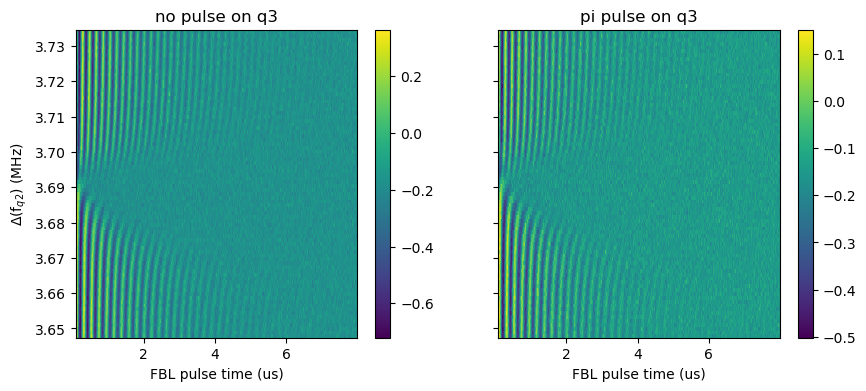

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(t_us, fq2_vec, q1_y_0, shading = 'auto')
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FBL pulse time (us)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(t_us, fq2_vec, q1_y_1, shading = 'auto')
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FBL pulse time (us)')

Text(0.5, 0, 'FBL pulse time (us)')

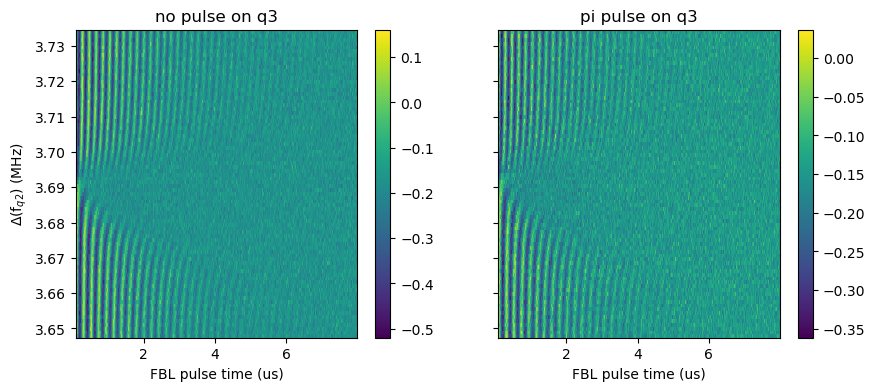

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(t_us, fq2_vec, q1_x_0, shading = 'auto')
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FBL pulse time (us)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(t_us, fq2_vec, q1_x_1, shading = 'auto')
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FBL pulse time (us)')

(0.0, 2.2)

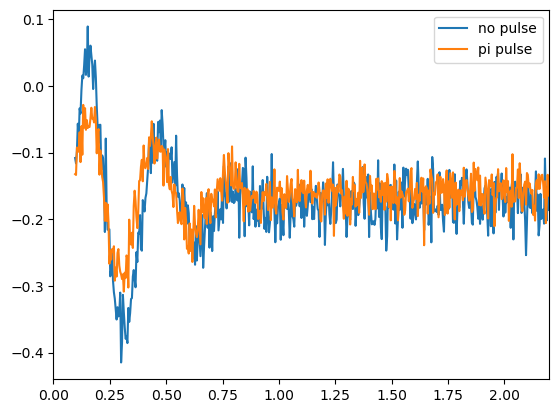

In [23]:
plt.plot(t_us, q1_x_0[35,:], label = 'no pulse')
plt.plot(t_us, q1_x_1[35,:], label = 'pi pulse')

plt.legend()
plt.xlim([0, 2.2])

In [24]:
FFT = np.abs(np.fft.fft(q1_x_0))
n = t_us.size
timestep = t_us[1] - t_us[0]
freq = np.fft.fftfreq(n, d=timestep)
freq_pos = freq[1:-freq.size//2]
FFT_pos = FFT[:,1:-FFT.shape[1]//2]
FFT_0 = FFT_pos
delta_vec_0= freq_pos[np.argmax(FFT_pos, axis = 1)]


FFT = np.abs(np.fft.fft(q1_x_1))
n = t_us.size
timestep = t_us[1] - t_us[0]
freq = np.fft.fftfreq(n, d=timestep)
freq_pos = freq[1:-freq.size//2]
FFT_pos = FFT[:,1:-FFT.shape[1]//2]
FFT_1 = FFT_pos
delta_vec_1= freq_pos[np.argmax(FFT_pos, axis = 1)]

C:\Users\gabri\AppData\Local\Temp\ipykernel_25736\3762577401.py:7: UserWarning: Matplotlib is currently using QtAgg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


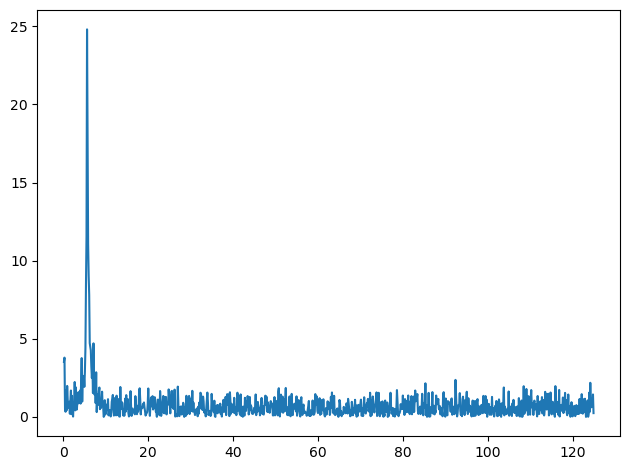

In [25]:
fig, ax = plt.subplots()

# ax.plot(freq_pos, FFT_0[10], 'g')
# ax.plot(freq_pos, FFT_1[10], 'r')
ax.plot(freq_pos, np.abs(FFT_0[50]- FFT_1[50]))
fig.tight_layout()
fig.show()

(-5.0, 5.0)

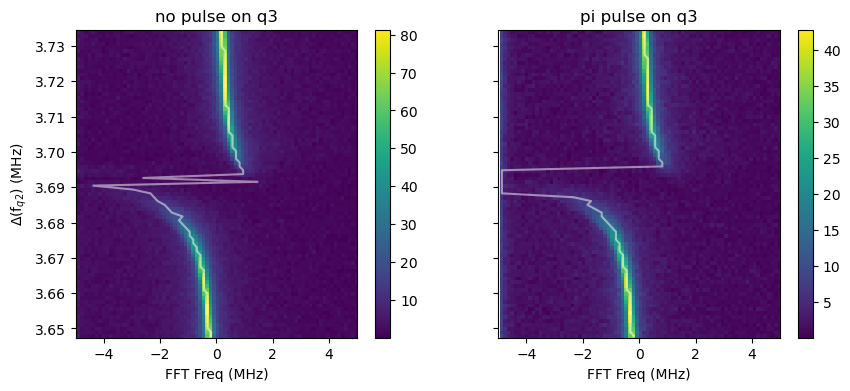

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

ax[0].set_title('no pulse on q3')
c = ax[0].pcolor(freq_pos - 5, fq2_vec, FFT_0, shading = 'auto')
ax[0].plot(delta_vec_0-5, fq2_vec, color = 'white', alpha = .5)
fig.colorbar(c, ax = ax[0])
ax[0].set_xlabel('FFT Freq (MHz)')
ax[0].set_ylabel('$\Delta$(f$_{q2}$) (MHz)')
ax[0].set_xlim([-5, 5])

ax[1].set_title('pi pulse on q3')
c = ax[1].pcolor(freq_pos - 5, fq2_vec, FFT_1, shading = 'auto')
ax[1].plot(delta_vec_1-5, fq2_vec, color = 'white', alpha = .5)
fig.colorbar(c, ax = ax[1])
ax[1].set_xlabel('FFT Freq (MHz)')
ax[1].set_xlim([-5,5])

## FFT not precise enough --> fit oscillations 

In [27]:
T2_vec_0 = np.empty(len(a_vec))
f_vec_0 = np.empty(len(a_vec))
T2_vec_1 = np.empty(len(a_vec))
f1_vec_1 = np.empty(len(a_vec))
f2_vec_1 = np.empty(len(a_vec))


In [28]:
popt_list_0 = []

In [29]:
A = 0.3
tau = 2.44
f = np.abs(delta_vec_0[0])
phase = 2.5
Offset = -0.15

idx = -1

for i in range(a_vec.size):

    #try:
    popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_y_0[i,:idx], p0=[A, tau, f, phase, Offset])
    T2_vec_0[i] = popt[1]
    f_vec_0[i] = popt[2]
 
    popt_list_0.append( popt )
    A = popt[0]
    tau = popt[1]
    f = popt[2]
    phase = popt[3]
    Offset = popt[4]
    
    
    

A = 0.3
tau = 2.44
f = np.abs(delta_vec_1[0])
phase = 2.5
Offset = -0.15

    
for i in range(a_vec.size):

    #try:
    popt, pcov = curve_fit(damped_oscillation, t_us[:idx], q1_y_1[i,:idx], p0=[A, tau, f, phase, Offset])
    # popt, pcov = curve_fit(damped_oscillation_2_freq, t_us[:idx], q1_y_1[i,:idx], p0=[A, tau, f, f/10, phase, phase, Offset])
    T2_vec_1[i] = popt[1]
    f1_vec_1[i] = popt[2]
    f2_vec_1[i] = popt[3]
 
      
    A = popt[0]
    tau = popt[1]
    f = popt[2]
    phase = popt[3]
    Offset = popt[4]

In [30]:
T2_vec_1.max()

1.900323616771475

In [31]:
i=10

C:\Users\gabri\AppData\Local\Temp\ipykernel_25736\38082816.py:7: UserWarning: Matplotlib is currently using QtAgg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


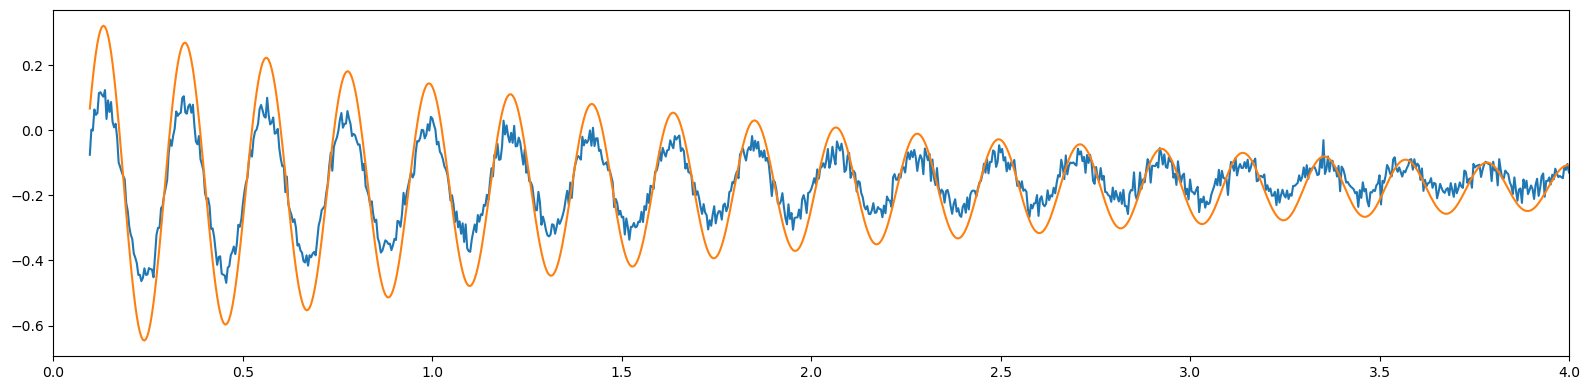

In [32]:
fig, ax = plt.subplots(figsize= [ 16,4])

ax.plot(t_us, q1_y_1[i,:])
ax.plot(t_us, damped_oscillation(t_us, *popt_list_0[i] ))
ax.set_xlim([0,4])
fig.tight_layout()
fig.show()

Text(0, 0.5, '$\\Delta fq_1$ (MHz)')

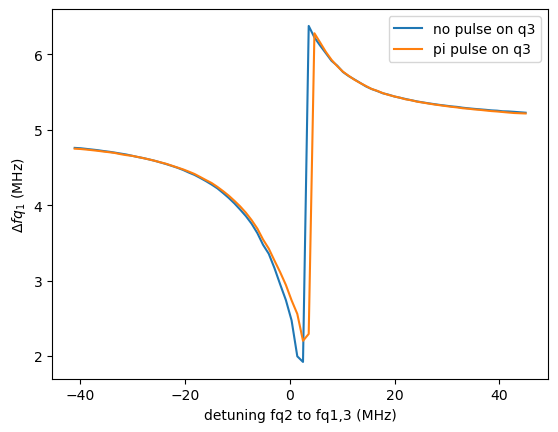

In [33]:
plt.plot(fq2_vec*1e3 - 3689, f_vec_0, '-', label = 'no pulse on q3')

# The curves overlap if we move fq1_1 by 1 MHz to the "left"
plt.plot(fq2_vec*1e3 - 3689, f1_vec_1, '-', label = 'pi pulse on q3')

plt.legend()

plt.xlabel('detuning fq2 to fq1,3 (MHz)')
plt.ylabel('$\Delta fq_1$ (MHz)')

How can we extract the zz interaction from this measurement? Is it 1 MHz?